# Wisdom Tree Assignment

We start by importing the libraries that we will need later on

In [1]:
import numpy as np
import pandas as pd
import os.path as pth

import matplotlib.pyplot as plt

from time import time
from WT_functions import backtest_strategy
from WT_functions import IndexConstruction
from WT_functions import single_commodity_optimal_contract
from WT_functions import plot_contract, plot_future_curve_and_roll_yield

## Get and Clean Data

As first steps, we:
- Get the dataframes we will need to perform the analysis from the `.csv` files, namely `contracts_prices.csv` and `contracts_info.csv`.
- Transform date columns into `pd.datetime`.
- Sort the DataFrame by index first (trading date), then by maturity year and maturity month.
- Merge the contracts' information DataFrame with `df` in order to compute the metrics that are involving the `contract_size`. 

In [2]:
filename = 'contracts_prices.csv' 
filename_info = 'contracts_info.csv'

filepath = pth.join(pth.join('Other', 'WisdomTree'), filename)  # insert here the right path
filepath_info = pth.join(pth.join('Other', 'WisdomTree'), filename_info)  # insert here the right path

df = pd.read_csv(filepath).set_index('date')
df_info = pd.read_csv(filepath_info).set_index('contract_code')
names_mapping = df_info.contract_short_name.to_dict()

# turn date columns into datetime dtype
df.index = pd.to_datetime(df.index, format='%d/%m/%Y')
df.loc[:, 'last_trade_date'] = pd.to_datetime(df['last_trade_date'], format='%d/%m/%Y')

df = df.reset_index().sort_values(['date', 'mat_year', 'mat_month'], ascending=[True, False, False]).set_index('date')
df = df.merge(df_info, left_on='contract_code', right_index=True)

We define the value of the contract by multiplying the current price by the size of the contract. Then we compute the open interest and the volume in USD and the 1 month (22 business days) moving average of the latter.


In [3]:
df['value_USD'] = df.close.mul(df.contract_size)
df['oi_USD'] = df.oi.mul(df.value_USD).fillna(0)
df['volume_USD'] = df.volume.mul(df.value_USD).fillna(0)

lbls = ['contract_code', 'mat_month', 'mat_year']
volume_ma = df.groupby(lbls)['volume_USD'].rolling(window=22, min_periods=1).mean()
df = df.set_index(lbls, append=True).join(volume_ma, rsuffix='_1M_MA').reset_index().set_index('date')

We wrapped up the previous code in a single function called `get_and_tidy_up_data`. We print how long does it take to ingest and tidy up the data

In [4]:
from WT_functions import get_and_tidy_up_data
df, names_mapping = get_and_tidy_up_data(filename='contracts_prices.csv', filename_info='contracts_info.csv')

func:'get_and_tidy_up_data' args:[(), {'filename': 'contracts_prices.csv', 'filename_info': 'contracts_info.csv'}] took: 10.7361 sec


## Some Plots

Now we use the function `plot_contract` to plot the metrics relative to specific contracts. 

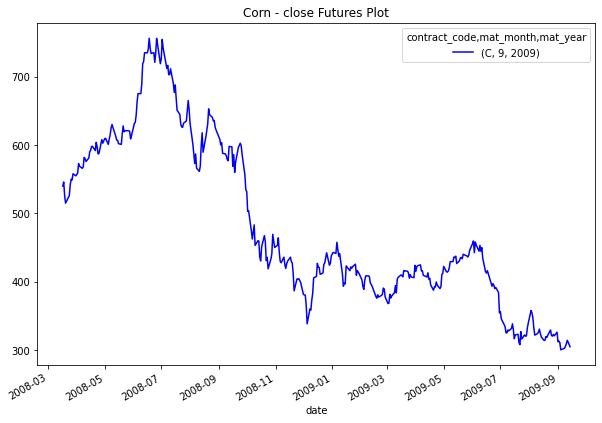

In [5]:
plot_contract('close', df, 'C', [9], [2009], names_mapping)

Below we plot the graphs of USD volume and open interest in log scale, so it's more clear when a contract availability kicks in.

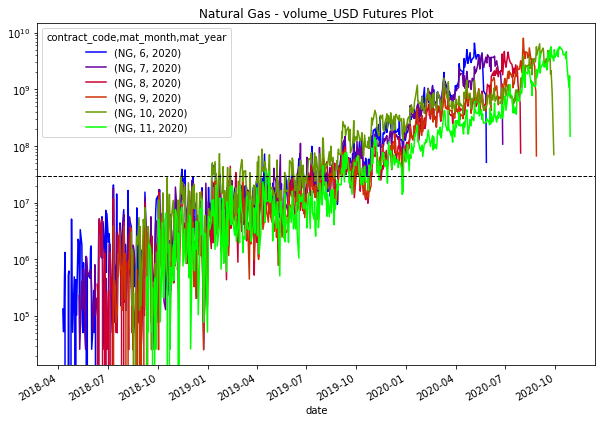

In [6]:
plot_contract('volume_USD', df, 'NG', [6, 7, 8, 9, 10, 11], [2020], names_mapping)

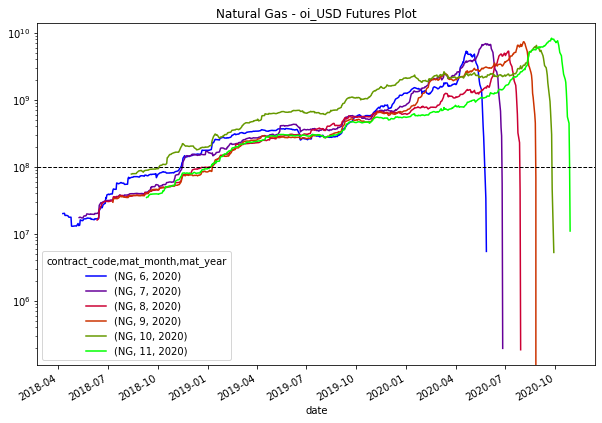

In [7]:
plot_contract('oi_USD', df, 'NG', [6, 7, 8, 9, 10, 11], [2020], names_mapping)

## Optimal Future Maturity

For each one of the commodity we have to find the *optimal future maturity* on the last day of each month. In order to to this, we first find the *optimal future maturity contract* for each day and then we will resample the Dataframe obtained in order to sample the right contract at each month end.

With the **implied roll yield** defined as

$$\text{Implied Roll Yield}_i = \bigg( \frac{\text{Price of contract}_{i-1}}{\text{Price of contract}_{i}} - 1 \bigg) \frac{1}{\text{# of months between the contracts}}$$

The **optimal future maturity** is defined, for each date, as the contract $i$ that satisfies:

$$\max_i \bigg( \text{Implied Roll Yield}_i \bigg)$$

Given that the it has an **open interest of at least 100 USD/mln** and **1-month average daily USD volume of at least 30 USD/mln**. We show the steps done in order to get to these values for one single commodity for clarity, namely Natural Gas.

In [8]:
volume_threshold=3e7
oi_threshold=1e8

cols = ['contract_code', 'mat_month', 'mat_year']  # columns employed in the groupbys

ng = df[df.contract_code == 'NG']

First let's put the close prices into a dataframe where the index is the date and the columns are the contracts.

In [9]:
price_ng_comm = ng.set_index(cols, append=True).loc[:, 'close'].unstack(cols)

# sort the columns properly
price_ng_comm.sort_index(level='mat_year', axis=1, inplace=True)

Now compute the number of days between two consecutive contracts and divide that by 30 (as a representative number for of number of days in one month). We obtain the column `delta_months`, that we will use in the calculation of the implied roll yield. To perform this operation and some of the following operations we will use the `groupby()` method of `pandas`, which allows some fast vectorized manipulation of data.

In [10]:
ng_grouped = ng.reset_index().groupby(['date', 'contract_code'])
delta_days = ng_grouped['last_trade_date'].diff().abs().dt.days.shift(-1)
delta_days.index = ng.index
ng.loc[:, 'delta_days'] = delta_days
ng.loc[:, 'delta_months'] = delta_days / 30

C:\Users\ilsup\Anaconda3\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


Then we compute the **roll yield for each contract**; we compute it with the simple `pct_change()` method. The contracts are ordered in such the way that `pct_change()` and a subsequent shift backwards of one day assign to each contract the right roll yield

In [11]:
roll_yield_raw = ng_grouped['close'].pct_change().shift(-1)
roll_yield_raw.index = ng.index
ng.loc[:, 'roll_yield_raw'] = roll_yield_raw
ng.loc[:, 'roll_yield'] = ng['roll_yield_raw'].div(ng['delta_months'])

Finally we filter each contract by the volume and open interest requirements

In [12]:
ng_flt = ng[(ng.volume_USD_1M_MA > volume_threshold) & (ng.oi_USD > oi_threshold)]

Now we have all the eligible contracts and the relative roll yields. The last thing to do is to **select the maximum one** per day

In [13]:
chosen_contracts_idx = list(ng_flt.reset_index().groupby(['date', 'contract_code'])['roll_yield'].idxmax().dropna().values.astype(int))
chosen_contracts = ng_flt.reset_index().iloc[chosen_contracts_idx].set_index('date')

Once we have all the "optimal" contracts, we simply

In [14]:
w_ng_mask = ~chosen_contracts.set_index(cols, append=True).loc[:, 'close'].unstack(cols).isnull()
w_ng = w_ng_mask.astype(float)  # convert bool for chosen contract in a float

# make sure that the weight matrix and price matrix have same indexes
w_ng = w_ng.reindex(price_ng_comm.index).reindex(price_ng_comm.columns, axis=1)
w_ng_mask = w_ng_mask.reindex(price_ng_comm.index).reindex(price_ng_comm.columns, axis=1)

We perform a small check in order to verify that only one contract is chosen by each date

In [15]:
w_ng.sum(axis=1).sum() == w_ng.shape[0]

True

### Visualize Optimal Future Maturity

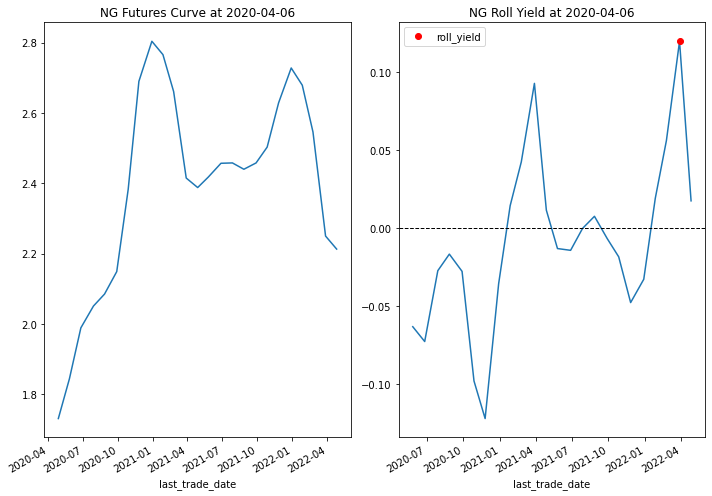

In [16]:
plot_future_curve_and_roll_yield(ng.loc[pd.to_datetime('2020-04-06')])

In the graph above we wanted to show visually ho the optimal maturity choice works. We plot on the right the **futures curve** for Natural gas. On the *x-axis* we have the **maturity** of the contracts and the **price** on the *y-axis*. We can notice the seasonality typical of natural gas futures. 

On the right hand side we have the roll yields and, **in red, the optimal one**. By selecting the contract with the highest roll yield we are basically trying to get the contract that, given the same futures curve shape, will have the highest percentage price pick up.

## Optimal Yield Choice Wrap Up

We wrap up everything in following `for` cycle. The function `single_commodity_optimal_contract`, for each commodity, performs the steps that we outlined previously and stores them in three dictionaries:
- `price_df_dict`: close prices are stored in dataframes where the index is the date and the columns are the contracts.
- `contracts_df_dict`: all the contracts with relative roll yields
- `chosen_contracts_dict`: where the contracts with the highest roll yield are stored. From this dictionary we will create the dataframe to be save in an excel file
- `weights_dict`

In [17]:
pd.options.mode.chained_assignment = None  # disable warning

# initialize dictionaries
weights_dict = {}
price_df_dict = {}
contracts_df_dict = {}
chosen_contracts_dict = {}

for cd in df.contract_code.unique():
    print('Choose Optimal Contract for Single Commodity: {}'.format(cd))
    contracts_df_single, chosen_contracts_single, price_df_single_comm, weights_single = \
        single_commodity_optimal_contract(df[df.contract_code == cd])
    
    weights_dict[cd] = weights_single
    price_df_dict[cd] = price_df_single_comm
    contracts_df_dict[cd] = contracts_df_single
    chosen_contracts_dict[cd] = chosen_contracts_single

Choose Optimal Contract for Single Commodity: LA
Choose Optimal Contract for Single Commodity: CL
Choose Optimal Contract for Single Commodity: LP
Choose Optimal Contract for Single Commodity: XB
Choose Optimal Contract for Single Commodity: HO
Choose Optimal Contract for Single Commodity: NG
Choose Optimal Contract for Single Commodity: C
Choose Optimal Contract for Single Commodity: GC
Choose Optimal Contract for Single Commodity: KC
Choose Optimal Contract for Single Commodity: W
Choose Optimal Contract for Single Commodity: LX
Choose Optimal Contract for Single Commodity: SI
Choose Optimal Contract for Single Commodity: S
Choose Optimal Contract for Single Commodity: SB
Choose Optimal Contract for Single Commodity: LC


We turn the `chosen_contracts_dict` into a Dataframe and save it as `optimal_maturity.xls`

In [18]:
pd.concat(chosen_contracts_dict).to_excel('optimal_maturity.xls')

C:\Users\ilsup\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  """Entry point for launching an IPython kernel.


## Backtesting the Strategy 



If we want to start from this section, download pickles: 

In [19]:
weights = pd.read_pickle('weights')
price_df = pd.read_pickle('price_df')

### Step by Step
As we did before, we show the steps of the backtesting process. First we select our sample commodity, natural gas. Second, **we shift the weights one day forward**. Indeed, the information regarding the optimal roll yield will be only implemented at the end of the day and effective the day after.

In [20]:
cd = 'NG'

price_df_single = price_df.loc[:, cd]
weights_single = weights.loc[:, cd]

weights = weights.shift().dropna(how='all')
price_df = price_df.truncate(before=weights.index[0])

We first drop the commodity column level and collapse all the other column levels into one single level. 

In [21]:
w = weights_single.copy()
prices = price_df_single.copy()

w.columns = w.columns.droplevel(0)
prices.columns = prices.columns.droplevel(0)

# create single level column to pass the DataFrame
w.columns = ['_'.join(map(str, x)) for x in w.columns]
prices.columns = ['_'.join(map(str, x)) for x in prices.columns]

We use the class `IndexConstruction` in order to build the strategy. 
- We first resample the weights at the first month business day by setting `resample('BMS')`. This is equivalent to rebalancing the portfolio the last business day of the month with the new rebalanced weights effective only from the first day of the following month.
- We set `rebalancing_f = weights`: this means that the portfolio will be rebalanced only at the dates in the `weights_at_reb_dt` matrix and that the weight will be allowed to drift during the month-
- We set `shift_periods = 0` since we already shifted the weights in a previous step.

In [22]:
weights_at_reb_dt = w.resample('BMS').first().fillna(0).copy()

In [23]:
idx_cls = IndexConstruction(prices, weights_at_reb_dt.T, name='strategy', rebalancing_f='weights', shift_periods=0)
idx_cls.get_index()

A way to visualize the contracts chosen is to see the heatmap of the weights for a single commodity (only 2000 days are shown). On the y-axis we have the dates and, on the x-axis, we have the specific contracts (we avoided to write the contract names). The purple stripe represents all the contracts available at a given date. The yellow one is the chosen one at each date.

C:\Users\ilsup\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


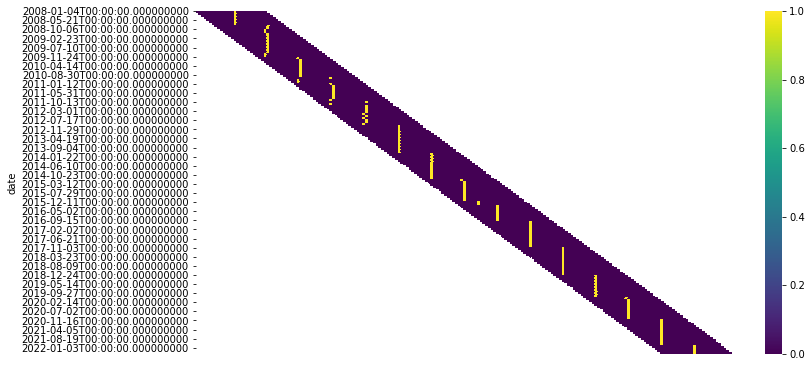

<Figure size 432x288 with 0 Axes>

In [24]:
idx_cls.plot_weights(heatmap=True)

Without going to much into detail, the `get_index()` first obtain the daily weights starting from the resampled weights and allowing them to drift, and then multiplies the weights by the prices. The core method that is called is the `get_weights()` which itself calls a very important function, `rebase_at_xs`. This function is the one that rebases the weights at a given date and let them drift until another date is encountered. It is what makes the implementation a bit slow and it can be definitely optimized and speeded up. We show the function below for clarity:

In [25]:
def rebase_at_xs(ri, at):
    """
    :param ri: pd.DataFrame; prices of the instruments
    :param at: pd.DataFrame; df that has rebalancing dates as columns and instrument codes as index
    """
    
    multiple_dts = at.columns
    df_dict = {}
    ri_reb = ri.copy()
    ri_reb = ri_reb.reindex(at.index.get_level_values(0).tolist(), axis=1)
    ri_reb = fillna_downbet(ri_reb)  # fill the dataframe only in the holes, 
    
    for i in np.arange(len(multiple_dts)):

        if i == 0:
            df = ri_reb.loc[:multiple_dts[i + 1], :].iloc[1:, :].dropna(how='all', axis=1)
        elif i + 1 == len(multiple_dts):
            df = ri_reb.loc[multiple_dts[i]:, :].iloc[1:, :].dropna(how='all', axis=1)
        else:
            df = ri_reb.loc[multiple_dts[i]:multiple_dts[i + 1], :].iloc[1:, :].dropna(how='all', axis=1)

        df_dict[i] = df.apply(lambda x: x / x.dropna().values.tolist()[0] * at.loc[x.name, multiple_dts[i]])

    df_to_go = pd.concat(df_dict)
    df_to_go.index = df_to_go.index.droplevel()
    return df_to_go

Since for some specific days not all the commodities' available contract have a price (for instance, at `2008-02-18` only three commodities have at least one contract with an available price. `LA`, `LP` and `LX`), we use the function called `fillna_downbet` that performs the forward fill only in the holes in the middle of a price time series, not at the end or at the beginning. 

The functions select every chunk between a rebalancing date and the following and **rescale the initial weight letting it drift just like the price**. Outside the function all the weights will be then rescaled to sum to 1. 

Obviously, for one single commodity, rebalancing monthly or daily is exactly the same, since the strategy is requiring to hold just one single  contract for each commodity per day. It is different if the daily rebalance targets the **optimal roll yield contract for each day**; we will test this later one

### Monthly Backtesting

If we want to start from here, download pickles: 

In [26]:
codes = df.contract_code.unique()

price_df = pd.concat(price_df_dict, axis=1)
weights = pd.concat(weights_dict, axis=1)

weights = weights.dropna(how='all')
price_df = price_df.truncate(before=weights.index[0])

empty_contracts = weights.sum()[weights.sum() == 0].index
price_df = price_df.drop(empty_contracts, axis=1)
weights = weights.drop(empty_contracts, axis=1)

ts_dict = {}
for cd in codes:
    print('Backtest Strategy For Single Commodity: {} - {}'.format(cd, 'Monthly Rebalancing'))
    price_df_single = price_df.loc[:, cd]
    weights_single = weights.loc[:, cd]
    strategy_class, strategy_ts = backtest_strategy(prices=price_df_single, w=weights_single, rebalancing='monthly')
    ts_dict[cd] = strategy_ts

print('Backtest Full Strategy')
ptf_class, ptf_ts = backtest_strategy(prices=price_df, w=weights, rebalancing='monthly')
ts_dict['portfolio'] = ptf_ts

Backtest Strategy For Single Commodity: LA - Monthly Rebalancing
Backtest Strategy For Single Commodity: CL - Monthly Rebalancing
Backtest Strategy For Single Commodity: LP - Monthly Rebalancing
Backtest Strategy For Single Commodity: XB - Monthly Rebalancing
Backtest Strategy For Single Commodity: HO - Monthly Rebalancing
Backtest Strategy For Single Commodity: NG - Monthly Rebalancing
Backtest Strategy For Single Commodity: C - Monthly Rebalancing
Backtest Strategy For Single Commodity: GC - Monthly Rebalancing
Backtest Strategy For Single Commodity: KC - Monthly Rebalancing
Backtest Strategy For Single Commodity: W - Monthly Rebalancing
Backtest Strategy For Single Commodity: LX - Monthly Rebalancing
Backtest Strategy For Single Commodity: SI - Monthly Rebalancing
Backtest Strategy For Single Commodity: S - Monthly Rebalancing
Backtest Strategy For Single Commodity: SB - Monthly Rebalancing
Backtest Strategy For Single Commodity: LC - Monthly Rebalancing
Backtest Full Strategy


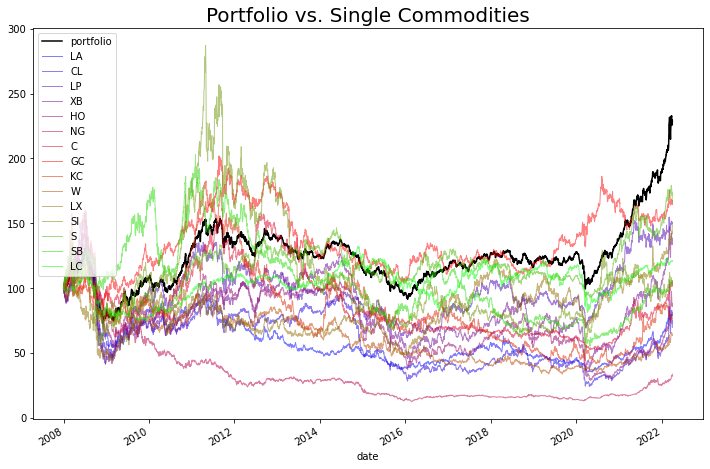

In [27]:
from WT_functions import rebase_at_x

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

to_plot = rebase_at_x(pd.concat(ts_dict, axis=1))

to_plot.loc[:, 'portfolio'].plot(color='black', ax=ax, legend=True)
to_plot.drop('portfolio', axis=1).plot(cmap='brg', ax=ax, alpha=0.5, linewidth=1)
ax.set_title('Portfolio vs. Single Commodities', fontsize=20)

plt.show()

To check wether our monthly rebalancing is working how it should, we plot the maximum weight over time (for the first 1000 days). We can see that at the beginning of each month the maximum weight goest to $\sim 6.6\%$ (which is one over number of commodities, i.e. 15). The, during the month, the maximum wieght drifts according to the performances of the underlying contracts.

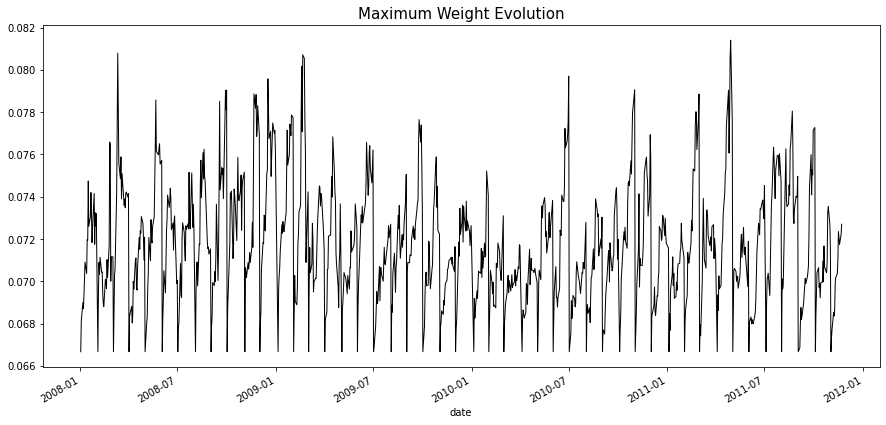

In [31]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1)
ptf_class.w_df.max(axis=1).iloc[:1000].plot(linewidth=1, color='black')
ax.set_title('Maximum Weight Evolution', fontsize=15)
plt.show()

### Daily Backtesting

In [29]:
ts_dict_daily = {}
for cd in codes:
    print('Backtest Strategy For Single Commodity: {} - {}'.format(cd, 'Daily Rebalancing'))
    price_df_single = price_df.loc[:, cd]
    weights_single = weights.loc[:, cd]
    strategy_class_daily, strategy_ts_daily = backtest_strategy(prices=price_df_single, w=weights_single, rebalancing='daily')
    ts_dict_daily[cd] = strategy_ts_daily

print('Backtest Full Strategy')
ptf_class_daily, ptf_ts_daily = backtest_strategy(prices=price_df, w=weights, rebalancing='daily')
ts_dict_daily['portfolio'] = ptf_ts

Backtest Strategy For Single Commodity: LA - Daily Rebalancing
Backtest Strategy For Single Commodity: CL - Daily Rebalancing
Backtest Strategy For Single Commodity: LP - Daily Rebalancing
Backtest Strategy For Single Commodity: XB - Daily Rebalancing
Backtest Strategy For Single Commodity: HO - Daily Rebalancing
Backtest Strategy For Single Commodity: NG - Daily Rebalancing
Backtest Strategy For Single Commodity: C - Daily Rebalancing
Backtest Strategy For Single Commodity: GC - Daily Rebalancing
Backtest Strategy For Single Commodity: KC - Daily Rebalancing
Backtest Strategy For Single Commodity: W - Daily Rebalancing
Backtest Strategy For Single Commodity: LX - Daily Rebalancing
Backtest Strategy For Single Commodity: SI - Daily Rebalancing
Backtest Strategy For Single Commodity: S - Daily Rebalancing
Backtest Strategy For Single Commodity: SB - Daily Rebalancing
Backtest Strategy For Single Commodity: LC - Daily Rebalancing
Backtest Full Strategy


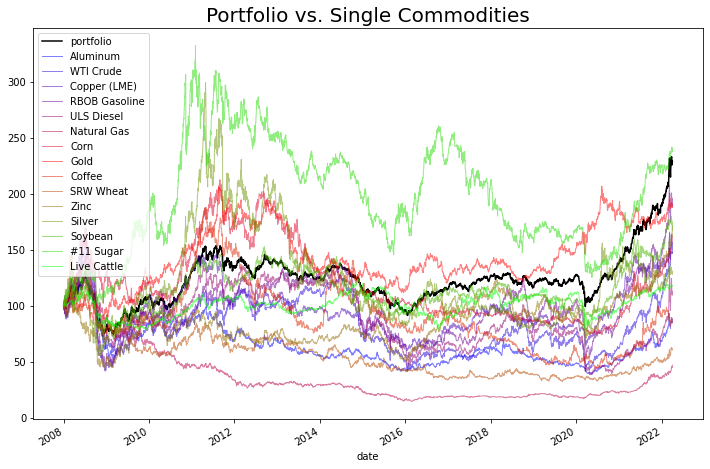

In [30]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

to_plot = rebase_at_x(pd.concat(ts_dict_daily, axis=1))

to_plot.loc[:, 'portfolio'].plot(color='black', ax=ax, legend=True)
to_plot.drop('portfolio', axis=1).rename(names_mapping, axis=1).plot(cmap='brg', ax=ax, alpha=0.5, linewidth=1)
ax.set_title('Portfolio vs. Single Commodities', fontsize=20)

plt.show()